In [1]:
from astral import LocationInfo
from astral.sun import sun
import datetime as dt
from pathlib import Path  
import pytz
from pytz import timezone
import matplotlib.pyplot as plt
from multiprocessing import Pool
import numpy as np
import os
from os import listdir
from os.path import isfile, join
import pandas as pd
import re
import seaborn as sns
import swifter
from swifter import set_defaults
import sys

In [2]:
set_defaults(
    npartitions=None,
    dask_threshold=1,
    scheduler="processes",
    progress_bar=True,
    progress_bar_desc=None,
    allow_dask_on_strings=True,
    force_parallel=False,
)

# Standardization


In [3]:
def get_standardized_datetime(row, originaltzstring):
    """
    Given a row representing one time series 
    point from a corrected white shark archival tag 
    file and a str of the timezone of the timestamps, 
    returns a datetime object for the event in 
    Pacific/Honolulu time.
    """
    originaltz = pytz.timezone(originaltzstring)
    originaldt = dt.datetime(row["Year"], row["Month"], row["Day"], row["Hour"], row["Min"], row["Sec"], 0, originaltz)
    return originaldt.astimezone(pytz.timezone("Pacific/Honolulu"))
    

def get_time_of_day(hour):
    """
    Given an int between 0 and 23 representing the
    hour of the day, returns the time of day 
    corresponding to that hour in Hawaii e.g.
    "Dawn," "Day," "Dusk," or "Night."
    """
    sunrise = 6
    sunset = 18

    if (hour in range(0, sunrise - 1)) or (hour in range(sunset + 1, 24)):
        return 'Night'
    elif hour in range(sunrise - 1, sunrise + 1):
        return 'Dawn'
    elif hour in range(sunrise + 1, sunset - 1):
        return 'Day'
    elif hour in range(sunset - 1, sunset + 1):
        return 'Dusk'
    else:
        return np.NaN


def get_plot_data(filename): 
    """
    Given a filename to corrected archival White Shark tag
    data, returns a pandas dataframe containing data for
    plotting
    """
    df = pd.read_csv(filename)
    
    # Get timezone of date/time
    dateColName = df.columns[0]
    originaltz = ''
    if dateColName == "Date(UTC-8)":
        originaltz = 'Etc/GMT+8' # why? no one knows
    elif dateColName == "Date(EST)":
        originaltz = 'UTC' # ehy? EST was mistake
    elif dateColName == "Date":
        originaltz = 'UTC'
    else:
        raise ValueError("Cannot processes timezone of Date column" + dateColName)
    
    # Build standard datetime
    df["Datetime (UTC-10)"] = df.swifter.apply(lambda row: get_standardized_datetime(row, originaltz), axis=1)
    
    # add hour column
    df["Hour (UTC-10)"] = df["Datetime (UTC-10)"].swifter.apply(lambda x: x.hour)
    
    # add time of day column
    df["Time of Day"] = df["Hour (UTC-10)"].swifter.apply(get_time_of_day)
    
    return df


def get_filepaths_in_dir(dir_path):
    """
    Given a directory path, return a list of files in the given directory.
    >>> get_files_in_dir('./test')
    ['test1.txt', 'test.txt']
    """
    only_files = [join(dir_path, f) for f in listdir(dir_path) if isfile(join(dir_path, f))]
    return only_files


def filter_csvs(filepaths):
    """
    Given a list of filepaths, returns a list containing only the csv filepaths 
    in the given list.
    """
    csv_files = [f for f in filepaths if '.csv' in f]
    return csv_files


def get_shark_ID(filepath):
    """
    Given string filepath, returns 7 digit shark ID in filepath
    name.
    """
    # pattern matches any sequence of 7 digits
    pattern = '\\d{7}'

    sharkIDMatch = re.search(pattern, filepath)
    assert sharkIDMatch, 'Could not find 7 digit ID in filepath: {}'.format(filepath)
    
    sharkID = sharkIDMatch.group(0)
    return sharkID + '00'

In [4]:
# all Hawaii white shark archival files
files = filter_csvs(get_filepaths_in_dir('./data/hawaii_data/original'))

# metadata for Hawaii white sharks with Id, tag number, 
# ptt, tagging date, length, sex, and first/last date
# that shark was in Hawaiian lees
meta_df = pd.read_csv('./data/meta_data.csv')

# build a master dataframe containing these columns for all Hawaii white sharks
columns = ["Id", "Datetime (UTC-10)", "Hour (UTC-10)", "Time of Day", "Depth(m)", "External Temp (c)", "Sex", "Shark Length (cm)"] # add all the other stuff just incase
dfs = []

for file in sorted(files):
    df = get_plot_data(file)
    shark_id = get_shark_ID(file)
    df['Id'] = shark_id
    sex = meta_df[meta_df['eventid'] == int(shark_id) ]['sex'].iloc[0]
    df['Sex'] = sex
    df['External Temp (c)'] = df['ExtTemp(C)']
    df['Shark Length (cm)'] = meta_df[meta_df['eventid'] == int(shark_id) ]['length'].iloc[0]
    df = df[columns]

    # uncomment for re-sampling
    # # standardize sample frequency in master dataframe
    # if shark_id == '190000400':
    #     df = df.iloc[::30, :]
    # elif (shark_id == '190400900') or (shark_id == '190502800') or (shark_id == '190600200'):
    #     df = df.iloc[::60, :]
    # elif shark_id == '190601200':
    #     df = df.iloc[::240, :]
    # elif shark_id == '190900200':
    #     df = df.iloc[::360, :]

    dfs.append(df)

combined = pd.concat(dfs, ignore_index=True)

Dask Apply:   0%|          | 0/32 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/74310 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/74310 [00:00<?, ?it/s]

Dask Apply:   0%|          | 0/32 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/116640 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/116640 [00:00<?, ?it/s]

Dask Apply:   0%|          | 0/32 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/87840 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/87840 [00:00<?, ?it/s]

Dask Apply:   0%|          | 0/32 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/125280 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/125280 [00:00<?, ?it/s]

Dask Apply:   0%|          | 0/32 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/673920 [00:00<?, ?it/s]

Dask Apply:   0%|          | 0/32 [00:00<?, ?it/s]

Dask Apply:   0%|          | 0/32 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/734400 [00:00<?, ?it/s]

Dask Apply:   0%|          | 0/32 [00:00<?, ?it/s]

# Calculating Time of Day Using Astral

In [5]:
"""Provides a `DateTimeRange` class, which is used for managing ranges of datetimes."""
import datetime

class DateTimeRange(object):
    """Represents a range of datetimes, with a start and (optionally) an end.
       
       Basically implements most of the methods on a standard sequence data type to provide
       some lovely syntactic sugar. Specifically, you can iterate on this, index it, slice it,
       use the in operator, reverse it, and use it in a boolean context to see if there is any
       time in between the start and end."""
    DEFAULT_STEP = datetime.timedelta(seconds=1)
    
    def __init__(self, start, end=None, step=DEFAULT_STEP, *args, **kwargs):
        self.start = start
        self.end = end
        self.step = step
        return super(DateTimeRange, self).__init__(*args, **kwargs)
    
    def __contains__(self, item):
        """Returns whether or not the passed datetime is within the range. Does not take into
           account the stride length from `self.step` -- if you need that use dateutil's rrule
           instead."""
        if self.end is None:
            # The range never ends, so we just need to check `item` is beyond the start
            return (self.start <= item)
        else:
            return (self.start <= item <= self.end)
    
    def __iter__(self):
        """Returns a generator which will yield datetime objects within the range, incrementing
           with `self.step` as its stride length on each iteration."""
        value = self.start
        while (value in self):
            yield value
            value += self.step
    
    def __reversed__(self):
        """Reverse iterator yielding the datetime objects within the range in reverse. Similarly
           to the forward-iterator, decrements (rather than increments) by `self.step` each time.
           
           This can only be called if an end is defined."""
        assert self.end is not None, 'Reverse iteration is not supported without an end'
        
        value = self.end
        while (value in self):
            yield value
            value -= self.step
    
    def __nonzero__(self):
        """Returns whether the date range covers a length of time (i.e. the end value is beyond
           the start). If no end is defined, always returns True as the range continues forever."""
        return ((not self.end) or (self.end > self.start))
    
    def __get_slice(self, start, stop, step=None):
        """Internal method for slicing the date range. Use the standard slicing syntax as the
           external interface."""
        indices = (xrange(start, stop, step) if step is not None else xrange(start, stop))
        result = []
        
        for index in indices:
            try:
                result.append(self[index])
            except IndexError:
                pass
        return result
    
    def __getitem__(self, key):
        """Returns the n'th datetime from the range, using `self.step` to determine the
           increment. Does not calculate every datetime up until the index, but rather
           multiplies the step value by the index to achieve the same result more efficiently.
           
           Negative indexing is only supported if an end is defined. Also supports slicing -- the
           same rule regarding negative indexing still applying."""
        if isinstance(key, tuple):
            # Multiple indices
            return [self[i] for i in key]
        elif isinstance(key, slice):
            # Slicing
            return self.__get_slice(start=key.start, stop=key.stop, step=key.step)
        else:
            # Regular indexing
            if key < 0:
                # Reverse-indexing
                assert self.end is not None, 'Negative indexing is not supported without an end'
                value = (self.end - (self.step * key))
            else:
                # Forward-indexing
                value = (self.start + (self.step * key))
            
            # Check that the value is in the range; return it if it is, raise IndexError if not
            if value in self:
                return value
            else:
                raise IndexError('index out of range')

In [6]:
# test inclusivity of class
one_hr = dt.timedelta(hours=1)
sunrise = dt.datetime(2020, 3, 21, 6, 0, 0).astimezone(pytz.timezone("Pacific/Honolulu"))
sunset = dt.datetime(2020, 3, 21, 18, 0, 0).astimezone(pytz.timezone("Pacific/Honolulu"))
ran = DateTimeRange(sunrise + one_hr, sunset - one_hr)
(sunset - one_hr) in ran # TRUE if DateTimeRange is end inclusive, FALSE else

True

In [7]:
def get_time_of_day_astral(date_time, lat, lon):
    """
    Given a datetime object in Hawaii time (UTC-10), 
    an int representing latitude, and an int representing 
    longitude, returns returns local apparent the time 
    of day corresponding to that hour in Hawaii e.g.
    "Dawn," "Day," "Dusk," or "Night."
    """
    # date_time = date_time.astimezone(pytz.timezone("Pacific/Honolulu")) # run this line if input date_time os not in Hawaii time
    if (date_time.date is None) or (date_time.year is None) or (date_time.month is None) or (date_time.day is None):
        raise ValueError("Cannot processes date with value: ", date)

    date_time_std = dt.datetime(date_time.year, date_time.month, date_time.day, date_time.hour, date_time.minute, date_time.second, 0, pytz.UTC)
    date_time_std = date_time_std.replace(tzinfo=pytz.timezone("Pacific/Honolulu"))

    location = LocationInfo("Honolulu", "Hawaii", "Pacific/Honolulu", lat, lon)
    s = sun(location.observer, date=datetime.date(date_time.year, date_time.month, date_time.day), tzinfo=location.timezone) 

    # time of day
    sunrise = s["sunrise"]
    sunrise_std = dt.datetime(sunrise.year, sunrise.month, sunrise.day, sunrise.hour, sunrise.minute, sunrise.second, 0, pytz.UTC)
    sunrise_std = sunrise_std.replace(tzinfo=pytz.timezone("Pacific/Honolulu"))

    sunset = s["sunset"]
    sunset_std = dt.datetime(sunset.year, sunset.month, sunset.day, sunset.hour, sunset.minute, sunset.second, 0, pytz.UTC)
    sunset_std = sunset_std.replace(tzinfo=pytz.timezone("Pacific/Honolulu"))

    one_hr = dt.timedelta(hours=1)
    one_s = dt.timedelta(seconds=1)

    midnight = dt.datetime(date_time.year, date_time.month, date_time.day, 0, 0, 0, 0, pytz.UTC)
    midnight = midnight.replace(tzinfo=pytz.timezone("Pacific/Honolulu"))
    
    pre_midnight = dt.datetime(date_time.year, date_time.month, date_time.day, 23, 59, 59, 0, pytz.UTC)
    pre_midnight = pre_midnight.replace(tzinfo=pytz.timezone("Pacific/Honolulu"))
    
    # DateTimeRange is inclusive of start and stop inputs
    if (date_time_std in DateTimeRange(midnight, sunrise_std - one_hr)) or (date_time_std in DateTimeRange(sunset_std + one_hr, pre_midnight)):
        return 'Night'
    elif date_time_std in DateTimeRange(sunrise_std - one_hr + one_s, sunrise_std + one_hr):
        return 'Dawn'
    elif date_time_std in DateTimeRange(sunrise_std + one_hr + one_s, sunset_std - one_hr):
        return "Day"
    elif date_time_std in DateTimeRange(sunset_std - one_hr + one_s, sunset_std + one_hr - one_s):
        return 'Dusk'
    else:
        return np.NaN

In [8]:
avg_lat = pd.read_csv('./data/hawaii_data/ws_hawaiionly_ssm_archivals_2022apr12.csv')["latitude"].mean()
avg_lon = pd.read_csv('./data/hawaii_data/ws_hawaiionly_ssm_archivals_2022apr12.csv')["longitude"].mean()
location = LocationInfo("Honolulu", "Hawaii", "Pacific/Honolulu", avg_lat, avg_lon)
s = sun(location.observer, dt.datetime.now(), tzinfo=location.timezone) 

pre_midnight = dt.datetime(dt.datetime.now().year, dt.datetime.now().month, dt.datetime.now().day, 23, 59, 59, 0, pytz.UTC)
pre_midnight = pre_midnight.replace(tzinfo=pytz.timezone("Pacific/Honolulu"))

s["sunrise"], pre_midnight

(datetime.datetime(2022, 8, 22, 6, 16, 32, 534548, tzinfo=<DstTzInfo 'Pacific/Honolulu' HST-1 day, 14:00:00 STD>),
 datetime.datetime(2022, 8, 22, 23, 59, 59, tzinfo=<DstTzInfo 'Pacific/Honolulu' LMT-1 day, 13:29:00 STD>))

In [9]:
# add a "Time of Day (Astral)" column" - time of day ("Dusk," "Dawn," etc.) calculated by the Astral API

# can parallelize with multiprocessing later https://stackoverflow.com/questions/45545110/make-pandas-dataframe-apply-use-all-cores 
avg_lat = pd.read_csv('./data/hawaii_data/ws_hawaiionly_ssm_archivals_2022apr12.csv')["latitude"].mean()
avg_lon = pd.read_csv('./data/hawaii_data/ws_hawaiionly_ssm_archivals_2022apr12.csv')["longitude"].mean()
combined["Time of Day (Astral)"] = combined.swifter.apply(lambda x: get_time_of_day_astral(x["Datetime (UTC-10)"], avg_lat, avg_lon), axis=1)

Dask Apply:   0%|          | 0/32 [00:00<?, ?it/s]

In [10]:
combined.info()
combined

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1812390 entries, 0 to 1812389
Data columns (total 9 columns):
 #   Column                Dtype                           
---  ------                -----                           
 0   Id                    object                          
 1   Datetime (UTC-10)     datetime64[ns, Pacific/Honolulu]
 2   Hour (UTC-10)         int64                           
 3   Time of Day           object                          
 4   Depth(m)              float64                         
 5   External Temp (c)     float64                         
 6   Sex                   object                          
 7   Shark Length (cm)     float64                         
 8   Time of Day (Astral)  object                          
dtypes: datetime64[ns, Pacific/Honolulu](1), float64(3), int64(1), object(4)
memory usage: 124.4+ MB


,Id,Datetime (UTC-10),Hour (UTC-10),Time of Day,Depth(m),External Temp (c),Sex,Shark Length (cm),Time of Day (Astral)
0,190000400,2001-01-02 18:59:50-10:00,18,Dusk,38.4,24.600002,M,457.0,Dusk
1,190000400,2001-01-02 19:01:50-10:00,19,Night,40.4,24.600002,M,457.0,Dusk
2,190000400,2001-01-02 19:03:50-10:00,19,Night,43.4,24.600002,M,457.0,Dusk
3,190000400,2001-01-02 19:05:50-10:00,19,Night,47.4,24.600002,M,457.0,Dusk
4,190000400,2001-01-02 19:07:50-10:00,19,Night,53.4,24.450001,M,457.0,Dusk
...,...,...,...,...,...,...,...,...,...
1812385,190900200,2009-06-09 13:59:10-10:00,13,Day,405.8,8.700000,F,427.0,Day
1812386,190900200,2009-06-09 13:59:20-10:00,13,Day,405.3,8.700000,F,427.0,Day
1812387,190900200,2009-06-09 13:59:30-10:00,13,Day,405.8,8.700000,F,427.0,Day
1812388,190900200,2009-06-09 13:59:40-10:00,13,Day,405.8,8.700000,F,427.0,Day


# Compare Orginal Time of Day with Time of Day Computed Using Astral

In [11]:
combined["Time of Day"].value_counts()

Night    755249
Day      755100
Dusk     151021
Dawn     151020
Name: Time of Day, dtype: int64

In [12]:
combined["Time of Day (Astral)"].value_counts()

Day      799323
Night    711042
Dawn     151020
Dusk     151005
Name: Time of Day (Astral), dtype: int64

In [13]:
# check for NaN
combined[combined['Time of Day'].isna()]
combined[combined['Time of Day (Astral)'].isna()]

,Id,Datetime (UTC-10),Hour (UTC-10),Time of Day,Depth(m),External Temp (c),Sex,Shark Length (cm),Time of Day (Astral)


# Compute Velocities

In [14]:
dfs = []
for Id in meta_df['eventid']: # for each shark
    df = combined[combined['Id'] == str(Id)]
    
    # find depth dif in successive rows
    # negaitve values mean descending in depth
    # positive means ascending 
    df['Depth Diff (m)'] = df['Depth(m)'].diff(periods=-1) 
    
    # find vertical velocity using unique sampling period of PSAT
    sample_period = meta_df.loc[meta_df['eventid'] == Id]['Sampling Period (sec)'] 
    df['Vertical Velocity (m/s)'] = df.swifter.apply(lambda x: x["Depth Diff (m)"] / sample_period, axis=1)
    dfs.append(df)

combined = pd.concat(dfs, ignore_index=True)

/var/folders/57/9723dmls3r5f8py4fcxpmz1r0000gp/T/ipykernel_76132/3713021206.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Depth Diff (m)'] = df['Depth(m)'].diff(periods=-1)


Dask Apply:   0%|          | 0/32 [00:00<?, ?it/s]

/var/folders/57/9723dmls3r5f8py4fcxpmz1r0000gp/T/ipykernel_76132/3713021206.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Vertical Velocity (m/s)'] = df.swifter.apply(lambda x: x["Depth Diff (m)"] / sample_period, axis=1)
/var/folders/57/9723dmls3r5f8py4fcxpmz1r0000gp/T/ipykernel_76132/3713021206.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Depth Diff (m)'] = df['Depth(m)'].diff(periods=-1)


Dask Apply:   0%|          | 0/32 [00:00<?, ?it/s]

/var/folders/57/9723dmls3r5f8py4fcxpmz1r0000gp/T/ipykernel_76132/3713021206.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Vertical Velocity (m/s)'] = df.swifter.apply(lambda x: x["Depth Diff (m)"] / sample_period, axis=1)
/var/folders/57/9723dmls3r5f8py4fcxpmz1r0000gp/T/ipykernel_76132/3713021206.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Depth Diff (m)'] = df['Depth(m)'].diff(periods=-1)


Dask Apply:   0%|          | 0/32 [00:00<?, ?it/s]

/var/folders/57/9723dmls3r5f8py4fcxpmz1r0000gp/T/ipykernel_76132/3713021206.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Vertical Velocity (m/s)'] = df.swifter.apply(lambda x: x["Depth Diff (m)"] / sample_period, axis=1)
/var/folders/57/9723dmls3r5f8py4fcxpmz1r0000gp/T/ipykernel_76132/3713021206.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Depth Diff (m)'] = df['Depth(m)'].diff(periods=-1)


Dask Apply:   0%|          | 0/32 [00:00<?, ?it/s]

/var/folders/57/9723dmls3r5f8py4fcxpmz1r0000gp/T/ipykernel_76132/3713021206.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Vertical Velocity (m/s)'] = df.swifter.apply(lambda x: x["Depth Diff (m)"] / sample_period, axis=1)
/var/folders/57/9723dmls3r5f8py4fcxpmz1r0000gp/T/ipykernel_76132/3713021206.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Depth Diff (m)'] = df['Depth(m)'].diff(periods=-1)


Dask Apply:   0%|          | 0/32 [00:00<?, ?it/s]

/var/folders/57/9723dmls3r5f8py4fcxpmz1r0000gp/T/ipykernel_76132/3713021206.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Vertical Velocity (m/s)'] = df.swifter.apply(lambda x: x["Depth Diff (m)"] / sample_period, axis=1)
/var/folders/57/9723dmls3r5f8py4fcxpmz1r0000gp/T/ipykernel_76132/3713021206.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Depth Diff (m)'] = df['Depth(m)'].diff(periods=-1)


Dask Apply:   0%|          | 0/32 [00:00<?, ?it/s]

/var/folders/57/9723dmls3r5f8py4fcxpmz1r0000gp/T/ipykernel_76132/3713021206.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Vertical Velocity (m/s)'] = df.swifter.apply(lambda x: x["Depth Diff (m)"] / sample_period, axis=1)


<AxesSubplot:xlabel='Datetime (UTC-10)'>

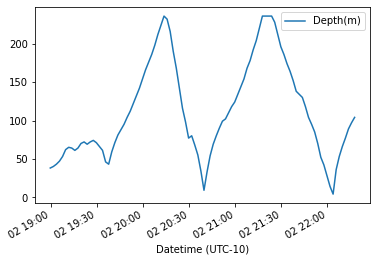

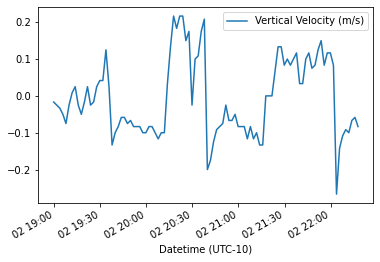

In [15]:
# quick check
combined.head(100).plot(x='Datetime (UTC-10)', y='Depth(m)')
combined.head(100).plot(x='Datetime (UTC-10)', y='Vertical Velocity (m/s)')

In [16]:
combined
combined[combined['Vertical Velocity (m/s)'].isna()]

,Id,Datetime (UTC-10),Hour (UTC-10),Time of Day,Depth(m),External Temp (c),Sex,Shark Length (cm),Time of Day (Astral),Depth Diff (m),Vertical Velocity (m/s)
74309,190000400,2001-04-15 23:57:50-10:00,23,Night,223.6,15.900002,M,457.00,Night,NaN,NaN
190949,190400900,2005-06-10 13:59:00-10:00,13,Day,533.1,7.050000,F,396.00,Day,NaN,NaN
278789,190502800,2006-05-30 13:59:00-10:00,13,Day,217.1,15.450001,F,480.00,Day,NaN,NaN
404069,190600200,2006-09-03 13:59:00-10:00,13,Day,1.2,26.700000,F,400.00,Day,NaN,NaN
1077989,190601200,2007-06-05 13:59:45-10:00,13,Day,197.2,17.750000,M,426.72,Day,NaN,NaN
1812389,190900200,2009-06-09 13:59:50-10:00,13,Day,405.3,8.700000,F,427.00,Day,NaN,NaN


In [17]:
combined['Speed (m/s)'] = combined['Vertical Velocity (m/s)'].swifter.apply(np.abs)
combined

,Id,Datetime (UTC-10),Hour (UTC-10),Time of Day,Depth(m),External Temp (c),Sex,Shark Length (cm),Time of Day (Astral),Depth Diff (m),Vertical Velocity (m/s),Speed (m/s)
0,190000400,2001-01-02 18:59:50-10:00,18,Dusk,38.4,24.600002,M,457.0,Dusk,-2.0,-0.016667,0.016667
1,190000400,2001-01-02 19:01:50-10:00,19,Night,40.4,24.600002,M,457.0,Dusk,-3.0,-0.025000,0.025000
2,190000400,2001-01-02 19:03:50-10:00,19,Night,43.4,24.600002,M,457.0,Dusk,-4.0,-0.033333,0.033333
3,190000400,2001-01-02 19:05:50-10:00,19,Night,47.4,24.600002,M,457.0,Dusk,-6.0,-0.050000,0.050000
4,190000400,2001-01-02 19:07:50-10:00,19,Night,53.4,24.450001,M,457.0,Dusk,-9.0,-0.075000,0.075000
...,...,...,...,...,...,...,...,...,...,...,...,...
1812385,190900200,2009-06-09 13:59:10-10:00,13,Day,405.8,8.700000,F,427.0,Day,0.5,0.050000,0.050000
1812386,190900200,2009-06-09 13:59:20-10:00,13,Day,405.3,8.700000,F,427.0,Day,-0.5,-0.050000,0.050000
1812387,190900200,2009-06-09 13:59:30-10:00,13,Day,405.8,8.700000,F,427.0,Day,0.0,0.000000,0.000000
1812388,190900200,2009-06-09 13:59:40-10:00,13,Day,405.8,8.700000,F,427.0,Day,0.5,0.050000,0.050000


# Find the Moon Phase Using Astral

In [18]:
from astral import moon

In [19]:
def get_moon_phase(date_time):
    """
    Given a datetime object, returns the corresponding 
    moon phase as a string.
    """
    phase_num = moon.phase(datetime.date(date_time.year, date_time.month, date_time.day))

    # convert phase int to str
    if (phase_num >= 0.0) and (phase_num <= 6.99):
        return 'New Moon'
    elif (phase_num >= 7.0) and (phase_num <= 13.99):
        return 'First Quarter'
    elif (phase_num >= 14.0) and (phase_num <= 20.99):
        return 'Full Moon'
    elif (phase_num >= 21.0) and (phase_num <= 27.99):
        return 'Last Quarter'
    else:
        return np.NaN

In [20]:
# populate a moon phase column
combined['Moon Phase'] = combined.swifter.apply(lambda x: get_moon_phase(x["Datetime (UTC-10)"]), axis=1)
combined

Dask Apply:   0%|          | 0/32 [00:00<?, ?it/s]

,Id,Datetime (UTC-10),Hour (UTC-10),Time of Day,Depth(m),External Temp (c),Sex,Shark Length (cm),Time of Day (Astral),Depth Diff (m),Vertical Velocity (m/s),Speed (m/s),Moon Phase
0,190000400,2001-01-02 18:59:50-10:00,18,Dusk,38.4,24.600002,M,457.0,Dusk,-2.0,-0.016667,0.016667,New Moon
1,190000400,2001-01-02 19:01:50-10:00,19,Night,40.4,24.600002,M,457.0,Dusk,-3.0,-0.025000,0.025000,New Moon
2,190000400,2001-01-02 19:03:50-10:00,19,Night,43.4,24.600002,M,457.0,Dusk,-4.0,-0.033333,0.033333,New Moon
3,190000400,2001-01-02 19:05:50-10:00,19,Night,47.4,24.600002,M,457.0,Dusk,-6.0,-0.050000,0.050000,New Moon
4,190000400,2001-01-02 19:07:50-10:00,19,Night,53.4,24.450001,M,457.0,Dusk,-9.0,-0.075000,0.075000,New Moon
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1812385,190900200,2009-06-09 13:59:10-10:00,13,Day,405.8,8.700000,F,427.0,Day,0.5,0.050000,0.050000,Full Moon
1812386,190900200,2009-06-09 13:59:20-10:00,13,Day,405.3,8.700000,F,427.0,Day,-0.5,-0.050000,0.050000,Full Moon
1812387,190900200,2009-06-09 13:59:30-10:00,13,Day,405.8,8.700000,F,427.0,Day,0.0,0.000000,0.000000,Full Moon
1812388,190900200,2009-06-09 13:59:40-10:00,13,Day,405.8,8.700000,F,427.0,Day,0.5,0.050000,0.050000,Full Moon


In [21]:
# check for missing values
combined[combined['Moon Phase'].isna()]

,Id,Datetime (UTC-10),Hour (UTC-10),Time of Day,Depth(m),External Temp (c),Sex,Shark Length (cm),Time of Day (Astral),Depth Diff (m),Vertical Velocity (m/s),Speed (m/s),Moon Phase


# Approximating max dive depth, dive length, and dive frequency

In [22]:
def get_max_depth(df, id):
    """
    Given a df containing columns
    'Id' and 'Depth(m)' returns the 
    maximum value from the 'Depth(m)'
    column for given 'Id'.
    """
    sh = df.loc[df['Id'] == id]
    return sh['Depth(m)'].max()

In [23]:
# find the max diving depth
meta_df['eventid'] = meta_df['eventid'].astype(str)
meta_df['Max Depth Recorded (m)'] = meta_df.swifter.apply(lambda row: get_max_depth(combined, row['eventid']), axis=1)

Dask Apply:   0%|          | 0/5 [00:00<?, ?it/s]

In [24]:
meta_df

,Unnamed: 0,eventid,tagnumber,ptt,taggingdate,length,sex,firstdate,lastdate,Sampling Period (sec),Max Depth Recorded (m)
0,0,190000400,00P0291,29711,2000-10-16,457.00,M,01/03/2001 05:00,04/16/2001 05:00,120,612.0
1,1,190400900,04P0160,52933,2004-11-30,396.00,F,03/22/2005 05:00,06/10/2005 05:00,60,981.1
2,2,190502800,05P0132,62021,2005-12-15,480.00,F,03/31/2006 05:00,05/30/2006 05:00,60,549.1
3,3,190600200,05P0059,60983,2006-01-21,400.00,F,06/09/2006 05:00,09/03/2006 05:00,60,580.8
4,4,190601200,06A0555,68281,2006-10-10,426.72,M,02/09/2007 05:00,06/05/2007 05:00,15,691.5
5,5,190900200,08A0599,87568,2009-01-19,427.00,F,03/17/2009 05:00,06/09/2009 05:00,10,990.9


In [25]:
# def get_hourly_dive_frequency(df):
#     """
#     Given a series of depth measurements (m)
#     spannig the course of an hour,
#     finds the number of unique times that depth
#     drops below 50 m.
#     """
#     result = 0

#     previous_depth = 0
#     for index, depth in df.iteritems():
#         if (previous_depth < 50) and (depth > 50):
#             result += 1
#         previous_depth = depth
    
#     return result

In [26]:
# dfs = []
# for Id in meta_df['eventid']:
#     sh = combined[combined['Id'] == str(id)]

#     sample_period_sec = meta_df[meta_df['eventid'] == Id]['Sampling Period (sec)']
#     num_samples_in_hour = int(3600 / sample_period_sec)
#     sh['Hourly Dive Frequency (dives/hr)'] = sh['Depth(m)'].rolling(num_samples_in_hour).apply(get_hourly_dive_frequency)
#     dfs.append(sh)

# combined = pd.concat(dfs, ignore_index=True)

In [27]:
combined

,Id,Datetime (UTC-10),Hour (UTC-10),Time of Day,Depth(m),External Temp (c),Sex,Shark Length (cm),Time of Day (Astral),Depth Diff (m),Vertical Velocity (m/s),Speed (m/s),Moon Phase
0,190000400,2001-01-02 18:59:50-10:00,18,Dusk,38.4,24.600002,M,457.0,Dusk,-2.0,-0.016667,0.016667,New Moon
1,190000400,2001-01-02 19:01:50-10:00,19,Night,40.4,24.600002,M,457.0,Dusk,-3.0,-0.025000,0.025000,New Moon
2,190000400,2001-01-02 19:03:50-10:00,19,Night,43.4,24.600002,M,457.0,Dusk,-4.0,-0.033333,0.033333,New Moon
3,190000400,2001-01-02 19:05:50-10:00,19,Night,47.4,24.600002,M,457.0,Dusk,-6.0,-0.050000,0.050000,New Moon
4,190000400,2001-01-02 19:07:50-10:00,19,Night,53.4,24.450001,M,457.0,Dusk,-9.0,-0.075000,0.075000,New Moon
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1812385,190900200,2009-06-09 13:59:10-10:00,13,Day,405.8,8.700000,F,427.0,Day,0.5,0.050000,0.050000,Full Moon
1812386,190900200,2009-06-09 13:59:20-10:00,13,Day,405.3,8.700000,F,427.0,Day,-0.5,-0.050000,0.050000,Full Moon
1812387,190900200,2009-06-09 13:59:30-10:00,13,Day,405.8,8.700000,F,427.0,Day,0.0,0.000000,0.000000,Full Moon
1812388,190900200,2009-06-09 13:59:40-10:00,13,Day,405.8,8.700000,F,427.0,Day,0.5,0.050000,0.050000,Full Moon


# Computing dive ratio
Vertical velocity used to split the depth record into vertical swimming phases (i.e., < 0 = descending, 0 = level swimming, > 0 = ascending). The proportion of time spent moving vertically (ascending and descending), termed the “diving ratio,” was also calculated by determining the percentage of time vertically moving within an hour, as described in Andrzejaczek et al., 2020.

In [30]:
# get mean hourly measurements
dfs = []

for file in sorted(files):
    
    Id = get_shark_ID(file)

    sh = combined[combined['Id'] == Id]

    # save original velocity column
    velocity = sh['Vertical Velocity (m/s)']

    # will merge on this column later
    sh['Date to join on'] = sh['Datetime (UTC-10)'].dt.strftime('%m-%d-%Y %H')

    # set all non-zero vv values to one
    sh.loc[sh['Vertical Velocity (m/s)'] > 0, 'Is non-zero VV'] = 1
    sh.loc[sh['Vertical Velocity (m/s)'] < 0, 'Is non-zero VV'] = 1

    # group my mm/dd HH and take average of those values to find diving ratio
    groups_by_mm_dd_hh = sh.groupby(sh['Datetime (UTC-10)'].dt.strftime('%m-%d-%Y %H')).mean()

    # delete unneccessary columns
    del groups_by_mm_dd_hh['Hour (UTC-10)']
    del groups_by_mm_dd_hh['Shark Length (cm)']
    del groups_by_mm_dd_hh['Depth Diff (m)']

    # rename columns
    groups_by_mm_dd_hh = groups_by_mm_dd_hh.rename(columns = {'Is non-zero VV': 'Hourly Diving Ratio', 'Depth(m)': 'Mean Hourly Depth (m)', 'External Temp (c)': 'Mean Hourly External Temp (c)', 'Speed (m/s)': 'Mean Hourly Speed (m/s)'})

    # merge on 'Date to join on'
    sh = sh.merge(groups_by_mm_dd_hh, left_on='Date to join on', right_on='Datetime (UTC-10)')
    del sh['Date to join on']
    del sh['Is non-zero VV']
    del sh['Vertical Velocity (m/s)_x']
    sh = sh.rename(columns = {'Vertical Velocity (m/s)_y': 'Vertical Velocity (m/s)'})

    dfs.append(sh)

combined = pd.concat(dfs, ignore_index=True)

/var/folders/57/9723dmls3r5f8py4fcxpmz1r0000gp/T/ipykernel_76132/4183685992.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sh['Date to join on'] = sh['Datetime (UTC-10)'].dt.strftime('%m-%d-%Y %H')
/var/folders/57/9723dmls3r5f8py4fcxpmz1r0000gp/T/ipykernel_76132/4183685992.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sh.loc[sh['Vertical Velocity (m/s)'] > 0, 'Is non-zero VV'] = 1
/var/folders/57/9723dmls3r5f8py4fcxpmz1r0000gp/T/ipykernel_76132/4183685992.py:14: SettingWithCopyWarning: 
A value

In [31]:
combined

,Id,Datetime (UTC-10),Hour (UTC-10),Time of Day,Depth(m),External Temp (c),Sex,Shark Length (cm),Time of Day (Astral),Depth Diff (m),Speed (m/s),Moon Phase,Mean Hourly Depth (m),Mean Hourly External Temp (c),Vertical Velocity (m/s),Mean Hourly Speed (m/s),Hourly Diving Ratio
0,190000400,2001-01-02 18:59:50-10:00,18,Dusk,38.4,24.600002,M,457.0,Dusk,-2.0,0.016667,New Moon,38.400000,24.600002,-0.016667,0.016667,1.0
1,190000400,2001-01-02 19:01:50-10:00,19,Night,40.4,24.600002,M,457.0,Dusk,-3.0,0.025000,New Moon,77.166667,23.610001,-0.035000,0.056111,1.0
2,190000400,2001-01-02 19:03:50-10:00,19,Night,43.4,24.600002,M,457.0,Dusk,-4.0,0.033333,New Moon,77.166667,23.610001,-0.035000,0.056111,1.0
3,190000400,2001-01-02 19:05:50-10:00,19,Night,47.4,24.600002,M,457.0,Dusk,-6.0,0.050000,New Moon,77.166667,23.610001,-0.035000,0.056111,1.0
4,190000400,2001-01-02 19:07:50-10:00,19,Night,53.4,24.450001,M,457.0,Dusk,-9.0,0.075000,New Moon,77.166667,23.610001,-0.035000,0.056111,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1812385,190900200,2009-06-09 13:59:10-10:00,13,Day,405.8,8.700000,F,427.0,Day,0.5,0.050000,Full Moon,412.559722,8.531944,0.000975,0.085376,1.0
1812386,190900200,2009-06-09 13:59:20-10:00,13,Day,405.3,8.700000,F,427.0,Day,-0.5,0.050000,Full Moon,412.559722,8.531944,0.000975,0.085376,1.0
1812387,190900200,2009-06-09 13:59:30-10:00,13,Day,405.8,8.700000,F,427.0,Day,0.0,0.000000,Full Moon,412.559722,8.531944,0.000975,0.085376,1.0
1812388,190900200,2009-06-09 13:59:40-10:00,13,Day,405.8,8.700000,F,427.0,Day,0.5,0.050000,Full Moon,412.559722,8.531944,0.000975,0.085376,1.0


# Surface Temperature
 Daily average sea surface temperature (SST) was estimated by averaging the temperature in the uppermost 5 m of the water column for each day (Andrzejaczek et al., 2018a). For days that white sharks did not enter this depth range, the estimate from the previous day was used.

# Extracting Helpful Metrics for Tableau

In [32]:
combined

,Id,Datetime (UTC-10),Hour (UTC-10),Time of Day,Depth(m),External Temp (c),Sex,Shark Length (cm),Time of Day (Astral),Depth Diff (m),Speed (m/s),Moon Phase,Mean Hourly Depth (m),Mean Hourly External Temp (c),Vertical Velocity (m/s),Mean Hourly Speed (m/s),Hourly Diving Ratio
0,190000400,2001-01-02 18:59:50-10:00,18,Dusk,38.4,24.600002,M,457.0,Dusk,-2.0,0.016667,New Moon,38.400000,24.600002,-0.016667,0.016667,1.0
1,190000400,2001-01-02 19:01:50-10:00,19,Night,40.4,24.600002,M,457.0,Dusk,-3.0,0.025000,New Moon,77.166667,23.610001,-0.035000,0.056111,1.0
2,190000400,2001-01-02 19:03:50-10:00,19,Night,43.4,24.600002,M,457.0,Dusk,-4.0,0.033333,New Moon,77.166667,23.610001,-0.035000,0.056111,1.0
3,190000400,2001-01-02 19:05:50-10:00,19,Night,47.4,24.600002,M,457.0,Dusk,-6.0,0.050000,New Moon,77.166667,23.610001,-0.035000,0.056111,1.0
4,190000400,2001-01-02 19:07:50-10:00,19,Night,53.4,24.450001,M,457.0,Dusk,-9.0,0.075000,New Moon,77.166667,23.610001,-0.035000,0.056111,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1812385,190900200,2009-06-09 13:59:10-10:00,13,Day,405.8,8.700000,F,427.0,Day,0.5,0.050000,Full Moon,412.559722,8.531944,0.000975,0.085376,1.0
1812386,190900200,2009-06-09 13:59:20-10:00,13,Day,405.3,8.700000,F,427.0,Day,-0.5,0.050000,Full Moon,412.559722,8.531944,0.000975,0.085376,1.0
1812387,190900200,2009-06-09 13:59:30-10:00,13,Day,405.8,8.700000,F,427.0,Day,0.0,0.000000,Full Moon,412.559722,8.531944,0.000975,0.085376,1.0
1812388,190900200,2009-06-09 13:59:40-10:00,13,Day,405.8,8.700000,F,427.0,Day,0.5,0.050000,Full Moon,412.559722,8.531944,0.000975,0.085376,1.0


In [33]:
meta_df


,Unnamed: 0,eventid,tagnumber,ptt,taggingdate,length,sex,firstdate,lastdate,Sampling Period (sec),Max Depth Recorded (m)
0,0,190000400,00P0291,29711,2000-10-16,457.00,M,01/03/2001 05:00,04/16/2001 05:00,120,612.0
1,1,190400900,04P0160,52933,2004-11-30,396.00,F,03/22/2005 05:00,06/10/2005 05:00,60,981.1
2,2,190502800,05P0132,62021,2005-12-15,480.00,F,03/31/2006 05:00,05/30/2006 05:00,60,549.1
3,3,190600200,05P0059,60983,2006-01-21,400.00,F,06/09/2006 05:00,09/03/2006 05:00,60,580.8
4,4,190601200,06A0555,68281,2006-10-10,426.72,M,02/09/2007 05:00,06/05/2007 05:00,15,691.5
5,5,190900200,08A0599,87568,2009-01-19,427.00,F,03/17/2009 05:00,06/09/2009 05:00,10,990.9


In [34]:
# pull out day, month, year
# combined['Day'] = combined['Datetime (UTC-10)'].dt.strftime('%d')



#  merge lat lon ?

In [35]:
# get mean daily SST estimates
dfs = []

for file in sorted(files):

    Id = get_shark_ID(file)
    
    sh = combined[combined['Id'] == Id]

    # will merge on this column later
    sh['Date to join on'] = sh['Datetime (UTC-10)'].dt.strftime('%m-%d-%Y')

    # filter data to rows with depth < 5 m
    filtered = sh[sh['Depth(m)'] <= 5]

    # goup by day and take .mean()
    grouped = filtered.groupby(filtered['Datetime (UTC-10)'].dt.strftime('%m-%d-%Y')).mean()

    # delete unneccessary columns
    del grouped['Hour (UTC-10)']
    del grouped['Depth(m)']
    del grouped['Shark Length (cm)']
    del grouped['Depth Diff (m)']
    del grouped['Vertical Velocity (m/s)']
    del grouped['Speed (m/s)']
    del grouped['Mean Hourly Depth (m)']
    del grouped['Mean Hourly External Temp (c)']
    del grouped['Hourly Diving Ratio']
    del grouped['Mean Hourly Speed (m/s)']

    # rename columns
    grouped = grouped.rename(columns = {'External Temp (c)': 'Daily SST Est (c)'})

    # merge on mo/d/Y
    sh = sh.merge(grouped, left_on='Date to join on', right_on='Datetime (UTC-10)')
    del sh['Date to join on']

    dfs.append(sh)

combined = pd.concat(dfs, ignore_index=True)

/var/folders/57/9723dmls3r5f8py4fcxpmz1r0000gp/T/ipykernel_76132/1923002435.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sh['Date to join on'] = sh['Datetime (UTC-10)'].dt.strftime('%m-%d-%Y')
/var/folders/57/9723dmls3r5f8py4fcxpmz1r0000gp/T/ipykernel_76132/1923002435.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sh['Date to join on'] = sh['Datetime (UTC-10)'].dt.strftime('%m-%d-%Y')
/var/folders/57/9723dmls3r5f8py4fcxpmz1r0000gp/T/ipykernel_76132/1923002435.py:11: SettingWithCopyWarning: 
A 

In [36]:
# no edge case to handle
combined
combined[combined['Daily SST Est (c)'].isna()]

,Id,Datetime (UTC-10),Hour (UTC-10),Time of Day,Depth(m),External Temp (c),Sex,Shark Length (cm),Time of Day (Astral),Depth Diff (m),Speed (m/s),Moon Phase,Mean Hourly Depth (m),Mean Hourly External Temp (c),Vertical Velocity (m/s),Mean Hourly Speed (m/s),Hourly Diving Ratio,Daily SST Est (c)


# Export Master as CSV

In [37]:
combined.to_csv('./data/hawaii_data/processed/master_hawaii.csv')

In [38]:
# export different sharks as different files
for id in meta_df['eventid']:
    sh = combined[combined['Id'] == str(id)]
    sh.to_csv('./data/hawaii_data/processed/' + str(id) + '.csv')

In [39]:
# export different sexes
fem = combined[combined['Sex'] == 'F']
mal = combined[combined['Sex'] == 'M']

fem.to_csv('./data/hawaii_data/processed/fem_master.csv')
mal.to_csv('./data/hawaii_data/processed/mal_master.csv')

In [40]:
# update meta data file
meta_df.to_csv('./data/meta_data.csv')